<a href="https://colab.research.google.com/github/tuonglong1012/Khai_Pha_Cuoi_Ky/blob/Hieu/CuoiKy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Mô tả Dataset**
*  Bộ dữ liệu **WeatherAUS** là tập dữ liệu dự báo thời tiết được thu thập bởi Cơ quan Khí tượng Úc (Australian Bureau of Meteorology).  
Dataset chứa thông tin thời tiết của nhiều trạm khí tượng trên khắp nước Úc trong giai đoạn **2007–2017**.

* Mục tiêu chính của bài toán là **dự đoán khả năng có mưa vào ngày mai** (`RainTomorrow`), một bài toán thuộc loại **phân loại nhị phân**.

---

### **Thông tin chung về dataset**
* **Số dòng dữ liệu:** ~145,000  
* **Số cột:** 23  
* **Dạng bài toán:** Classification  
* **Biến mục tiêu:** `RainTomorrow` (Yes/No => 1/0 sau khi mã hóa)

---

###  **Các nhóm thuộc tính chính**

#### 1. Thông tin vị trí
* `Location`: Tên trạm khí tượng (Sydney, Canberra, Darwin, …)

#### 2. Thông tin thời gian
* `Date`: Ngày quan sát (yyyy-mm-dd)

#### 3. Các thông số thời tiết ghi nhận
* `MinTemp`: Nhiệt độ thấp nhất trong ngày (°C)
* `MaxTemp`: Nhiệt độ cao nhất trong ngày (°C)
* `Rainfall`: Lượng mưa ghi nhận (mm)
* `Evaporation`: Lượng bốc hơi (mm)
* `Sunshine`: Số giờ nắng
* `WindGustSpeed`: Tốc độ gió giật mạnh nhất (km/h)
* `WindSpeed9am`, `WindSpeed3pm`: Tốc độ gió tại 9h/15h
* `Humidity9am`, `Humidity3pm`: Độ ẩm
* `Pressure9am`, `Pressure3pm`: Áp suất khí quyển
* `Cloud9am`, `Cloud3pm`: Mức độ mây (0–8)
* `Temp9am`, `Temp3pm`: Nhiệt độ tại 9h/15h

#### 4. Các thông tin về mưa
* `RainToday`: (Yes/No)
* `RainTomorrow`: **biến mục tiêu**

---

### **Một số vấn đề về bộ dữ liệu**
* Nhiều giá trị bị thiếu (đặc biệt ở: `Evaporation`, `Sunshine`, `Cloud9am`, `Cloud3pm`).
* Dữ liệu không đồng đều giữa các địa điểm.
* Nhiều biến numeric chứa outliers (Rainfall, WindGustSpeed,…).
* Dữ liệu chưa được chuẩn hóa thang đo.


### 1. Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Đọc dữ liệu và xem kích thước

In [3]:
df = pd.read_csv('/content/drive/MyDrive/KPDL/CuoiKy/weatherAUS.csv')
df.head(), df.shape

(         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
 0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
 1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
 2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
 3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
 4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
 
   WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
 0           W           44.0          W  ...        71.0         22.0   
 1         WNW           44.0        NNW  ...        44.0         25.0   
 2         WSW           46.0          W  ...        38.0         30.0   
 3          NE           24.0         SE  ...        45.0         16.0   
 4           W           41.0        ENE  ...        82.0         33.0   
 
    Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
 0 

### 3. Kiểm tra dữ liệu bị thiếu


*   Xác định các cột bị thiếu và thiếu bao nhiêu phần trăm.
*   Từ đó quyết định cột nào cần loại hoặc thay thế giá trị



In [4]:
missing_df = pd.DataFrame({
    'Missing Values': df.isna().sum(), # Đếm số giá trị NaN
    'Missing (%)': df.isna().mean() * 100 # Tính tỷ lệ %
})

missing_df.sort_values(by='Missing (%)', ascending=False)

,Missing Values,Missing (%)
Sunshine,69835,48.009762
Evaporation,62790,43.166506
Cloud3pm,59358,40.807095
Cloud9am,55888,38.421559
Pressure9am,15065,10.356799
Pressure3pm,15028,10.331363
WindDir9am,10566,7.263853
WindGustDir,10326,7.098859
WindGustSpeed,10263,7.055548
Humidity3pm,4507,3.098446


### 4. Xóa và xử lý dữ liệu

*   Các biến như `Evaporation`, `Sunshine`, `Cloud9am`, `Cloud3pm` có % tỷ lệ thiếu quá nhiều (20-40% hoặc hơn) nên sẽ giữ lại các dòng đủ dữ liệu.
*   Tách dữ liệu thành 2 nhóm.
    *   num_cols = các cột dạng số (float, int)
        
        Ví dụ: Temp, Rainfall, Humidity...
    *   cat_cols = các cột dạng chữ / phân loại (object)
        
        Ví dụ: Location, WindDir9am, RainToday…
*   Điền giá trị thiếu cho các cột dạng số (numrical) sử dụng median.
*   Điền giá trị thiếu cho các cột dạng chữ (categorical) sử dụng mode.




In [5]:
cols = ['Sunshine', 'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm']
df = df.dropna(subset=cols)

# Chia numerical & categorical
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Numerical => median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Categorical => mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


### 5. Kiểm tra điều kiện và xử lý nhiễu (outlier)

*   Loại bỏ giá trị bất thường gây sai lệch mô hình.
*   Kiểm tra điều kiện vật lý (không thể có lượng mưa (`Rainfall`) âm, tốc độ gió (`WindSpeed`) quá cao…)
*   Áp dụng IQR (Q1–Q3) cho biến liên tục để xác định outlier.




In [6]:
# Xử lý nhiễu
df = df[df["Rainfall"] >= 0]

df["WindSpeed9am"] = np.where(df["WindSpeed9am"] > 150, 150, df["WindSpeed9am"])
df["WindSpeed3pm"] = np.where(df["WindSpeed3pm"] > 150, 150, df["WindSpeed3pm"])

df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


In [7]:
# Xử lý ngoại lệ bằng IQR
def cap_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < low, low,
                       np.where(df[col] > high, high, df[col]))

for col in num_cols:
    cap_outliers(col)

df[num_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000,64523.000000
mean,13.320488,23.959628,0.494280,5.275477,7.630281,40.398261,15.039722,19.511415,66.736265,50.479906,1017.378653,1014.953689,4.286456,4.349705,18.002858,22.452036
std,6.341744,6.864697,0.798198,3.200119,3.770226,12.357542,8.274719,8.368255,18.211587,20.231940,6.865084,6.842267,2.809267,2.656354,6.473460,6.727038
min,-5.650000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,20.000000,0.000000,999.000000,996.100000,0.000000,0.000000,-0.900000,3.700000
25%,8.600000,18.600000,0.000000,2.800000,4.900000,31.000000,9.000000,13.000000,56.000000,36.000000,1012.800000,1010.200000,1.000000,2.000000,13.000000,17.200000
50%,13.100000,23.500000,0.000000,4.800000,8.500000,39.000000,15.000000,19.000000,68.000000,51.000000,1017.300000,1014.800000,5.000000,5.000000,17.600000,22.000000
75%,18.100000,29.200000,0.800000,7.200000,10.600000,48.000000,20.000000,24.000000,80.000000,64.000000,1022.000000,1019.600000,7.000000,7.000000,22.900000,27.500000
max,31.400000,45.100000,2.000000,13.800000,14.500000,73.500000,36.500000,40.500000,100.000000,100.000000,1035.800000,1033.700000,9.000000,9.000000,37.750000,42.950000


### Biểu đồ tương quan

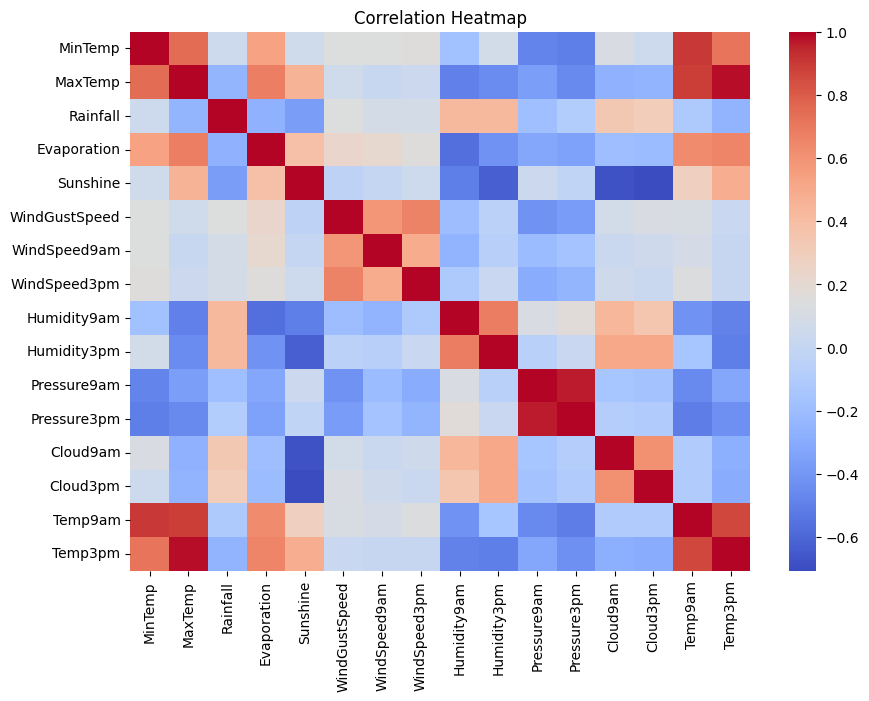

In [8]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

* Kết quả cho thấy `Humidity3pm`, `Rainfall` và `RainToday` có mức tương quan cao nhất với biến mục tiêu `RainTomorrow`, chứng tỏ các yếu tố độ ẩm và lượng mưa trong ngày hiện tại đóng vai trò quan trọng trong việc dự đoán khả năng mưa của ngày tiếp theo.

* Ngoài ra, một số cặp biến có tương quan mạnh với nhau như `Temp9am` – `Temp3pm` và `WindSpeed9am` – `WindSpeed3pm` cho thấy tính dư thừa thông tin. Việc nhận diện hỗ trợ cho quá trình chọn lọc đặc trưng giúp loại bỏ các thuộc tính trùng lặp và tối ưu mô hình dự đoán.


### 6. Mã hóa dữ liệu phân loại và chọn lọc thuộc tính (Feature Selection)

*   Chuyển dữ liệu dạng chữ thành dạng số, chuẩn hóa dữ liệu để xây dựng mô hình dự đoán.
*   Hỗ trợ các thuật toán cần số liệu (KNN, Logistic Regression, SVM…).
*   Tính mức độ khác biệt giữa các nhóm của biến mục tiêu để xác định các biến quan trọng nhất và loại bỏ các biến dư thừa nhằm tối ưu hóa mô hình.

In [9]:
# Chuẩn bị cho SelectKBest
df_encoded = df.copy()
le = LabelEncoder()

for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

X = df_encoded.drop("RainTomorrow", axis=1)
y = df_encoded["RainTomorrow"]

# SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)

scores = pd.DataFrame({
    "Feature": X.columns,
    "Score": selector.scores_
})

scores.sort_values("Score", ascending=False)

,Feature,Score
6,Sunshine,16614.344545
14,Humidity3pm,16559.615650
18,Cloud3pm,11692.642647
4,Rainfall,8065.582266
17,Cloud9am,7504.650715
21,RainToday,6996.118601
13,Humidity9am,5180.887235
15,Pressure9am,4508.329275
16,Pressure3pm,3633.700462
8,WindGustSpeed,3307.705014


### Top 10 thuộc tính quan trọng nhất

In [10]:
top_features = scores.sort_values("Score", ascending=False).head(10)
top_features

,Feature,Score
6,Sunshine,16614.344545
14,Humidity3pm,16559.615650
18,Cloud3pm,11692.642647
4,Rainfall,8065.582266
17,Cloud9am,7504.650715
21,RainToday,6996.118601
13,Humidity9am,5180.887235
15,Pressure9am,4508.329275
16,Pressure3pm,3633.700462
8,WindGustSpeed,3307.705014


### 7. Chuẩn hóa dữ liệu (StandardScaler)

*   Đưa tất cả biến về cùng thang đo mean=0, std=1.
*   Giúp mô hình như KNN, SVM, Logistic Regression hoạt động hiệu quả.



In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[-1.50609527, -1.09548421,  0.72212749,  1.63742982, -0.61924941,
         2.10135183,  1.23858757,  0.79493188,  0.61515453, -1.2956854 ,
         0.92122749, -1.09245913,  0.05838604, -2.5663127 , -1.85252608,
        -1.61378037, -1.54243786, -0.813904  ,  0.24480933,  1.32807018,
         1.62746939, -0.54329958],
       [-1.50492188, -1.09548421,  0.80097077,  0.71968366, -0.61924941,
         2.66383534,  1.42425426,  0.19523365, -0.27499704,  0.63773954,
         0.49934599,  0.47860337, -0.06111412, -2.01720747, -2.09966198,
        -0.65238634, -0.41707106, -1.16987149, -1.26102564,  0.35485815,
         0.67607753, -0.54329958],
       [-1.5025751 , -1.09548421,  0.95865733,  1.9870474 , -0.61924941,
         1.72636283,  0.78768277, -0.40446457,  0.45330879, -0.43638543,
        -0.34441701,  1.80796396, -0.53911475, -1.35828121, -1.40768146,
        -0.7397858 , -0.8409105 , -1.16987149,  0.62126807,  1.6524742 ,
         1.85045186, -0.54329958],
       [-1.50140172